# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [232]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [233]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 60000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (60000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [234]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [235]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [236]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [237]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [238]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [239]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [240]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(54458, 10)

In [241]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

90.76333333333334

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [242]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [243]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [244]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(54456, 10)


1    45572
0     8884
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [245]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
My whole family loves this sauce. I use it primarily to recreate a dish we had in Maui. It adds a wonderful sweet and spicy flavor to just about any sauce. Service on this order was spectacular. Several bottles arrived broken and replacements were received within days. Amazon service was fast, easy and reliable. I love Amazon. Also, there are many recipes that you can look up using this sauce that a very good. It goes spectaculary with coconut milk, vegetables, chicken or shrimp and pasta. We love it.
My husband is a paraplegic and was having UTIs constantly.  Since he started drinking a cup of this tea every morning, he hasn't had a UTI for a year.
THIS BREAD MIX IS THE CLOSEST THING TO REGULAR BREAD I HAVE FOUND. EASY TO MAKE IN MY BREAD MACHINE.


In [246]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [247]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
My whole family loves this sauce. I use it primarily to recreate a dish we had in Maui. It adds a wonderful sweet and spicy flavor to just about any sauce. Service on this order was spectacular. Several bottles arrived broken and replacements were received within days. Amazon service was fast, easy and reliable. I love Amazon. Also, there are many recipes that you can look up using this sauce that a very good. It goes spectaculary with coconut milk, vegetables, chicken or shrimp and pasta. We love it.
My husband is a paraplegic and was having UTIs constantly.  Since he started drinking a cup of this tea every morning, he hasn't had a UTI for a year.
THIS BREAD MIX IS THE CLOSEST THING TO REGULAR BREAD I HAVE FOUND. EASY TO MAKE IN MY BREAD MACHINE.


In [248]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [249]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

My husband is a paraplegic and was having UTIs constantly.  Since he started drinking a cup of this tea every morning, he has not had a UTI for a year.


In [250]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [251]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

My husband is a paraplegic and was having UTIs constantly Since he started drinking a cup of this tea every morning he has not had a UTI for a year 


In [252]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [253]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 54456/54456 [00:14<00:00, 3784.30it/s]


In [254]:
preprocessed_reviews[1500]

'husband paraplegic utis constantly since started drinking cup tea every morning not uti year'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [255]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [256]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (54456, 43297)
the number of unique words  43297


## [4.2] Bi-Grams and n-Grams.

In [257]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (54456, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [258]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able feed', 'able figure', 'able find']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (54456, 32341)
the number of unique words including both unigrams and bigrams  32341


## [4.4] Word2Vec

In [259]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [260]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8497111201286316), ('fantastic', 0.8297325968742371), ('terrific', 0.825562596321106), ('excellent', 0.8093761205673218), ('good', 0.7946046590805054), ('wonderful', 0.7789463996887207), ('amazing', 0.7778639793395996), ('perfect', 0.7478258609771729), ('nice', 0.7155869007110596), ('fabulous', 0.701867401599884)]
[('greatest', 0.7473974227905273), ('best', 0.7316523790359497), ('tastiest', 0.7120103240013123), ('nastiest', 0.698004961013794), ('softest', 0.663752555847168), ('experienced', 0.6557404398918152), ('closest', 0.6466886401176453), ('ive', 0.6298821568489075), ('horrible', 0.6290726661682129), ('awful', 0.618484377861023)]


In [261]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13942
sample words  ['dogs', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'made', 'china', 'satisfied', 'safe', 'loves', 'chicken', 'product', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'ca', 'not', 'beat', 'great']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [262]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 54456/54456 [01:27<00:00, 623.89it/s]

54456
50


#### [4.4.1.2] TFIDF weighted W2v

In [263]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [264]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 54456/54456 [14:37<00:00, 62.09it/s] 


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [265]:
# Please write all the code with proper documentation
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer()
X=bow.fit_transform(preprocessed_reviews)
inertia=[]
k=range(1,10)
for i in k:
    kmeans=KMeans(n_clusters=i).fit(X)
    inertia.append(kmeans.inertia_)

2


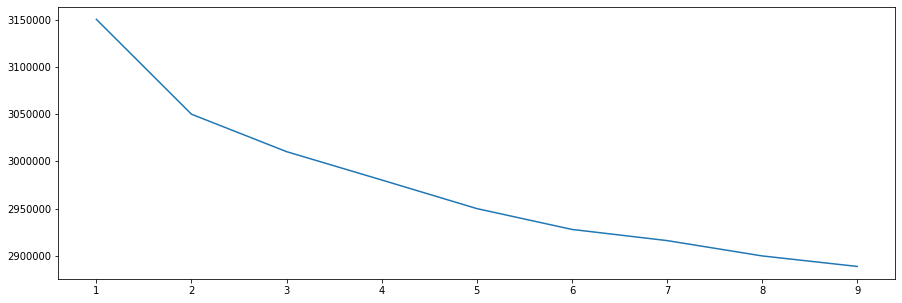

In [266]:
import math
#k vs inertia
fig,axs =  plt.subplots(1,1,squeeze=False,figsize=(15,5))
axs[0][0].plot(k,inertia)

best_k=1
maxx=-1
for i in range(len(inertia)-1):
    if abs(inertia[i+1]-inertia[i])>maxx:
        maxx=abs(inertia[i+1]-inertia[i])
        best_k+=1
print(best_k) 

In [268]:
kmeans=KMeans(n_clusters=best_k).fit(X)

In [269]:
kmeans.labels_.shape[0]
all_clusters=[]
clist=[]
for i in range(best_k):
    each_cluster=[]
    all_clusters.append(each_cluster)
    clist.append(i)
str_each_cluster=all_clusters

print(str_each_cluster)
index=None
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] in clist:
        index=clist.index(kmeans.labels_[i])
        all_clusters[index].append(str(preprocessed_reviews[i])) 
summ=0
for i in range(best_k):
    print('Number of reviews with label '+str(i)+' are '+str(len(all_clusters[i])))
    for h in range(0,len(all_clusters[i])):
        str_each_cluster[i]+=all_clusters[i][h]

[[], []]
Number of reviews with label 0 are 45549
Number of reviews with label 1 are 8907


In [270]:
print(kmeans.fit_predict(kmeans.cluster_centers_))

[1 0]


### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

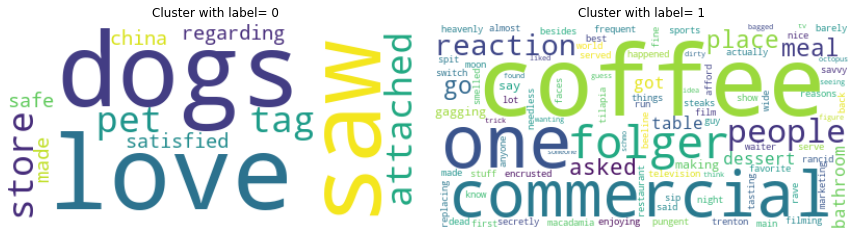

In [271]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
row=0
if best_k%2==0:
    row=best_k//2
else:
    row=best_k//2+1

fig,axs =  plt.subplots(row,2,squeeze=False,figsize=(12,12))
r,c=0,0
for i in range(best_k):
    if i%2!=0:
        c=+1
    else:
        c=0
        if i>1:
            r+=1
    wordcloud_spam = WordCloud(background_color="white").generate(str_each_cluster[i][0])
    axs[r][c].imshow(wordcloud_spam, interpolation='bilinear')
    axs[r][c].title.set_text("Cluster with label= "+str(i))
    axs[r][c].axis("off")
    fig.tight_layout()
plt.show()

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [272]:
# Please write all the code with proper documentation
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X=tfidf.fit_transform(preprocessed_reviews)
inertia=[]
k=range(1,10)
for i in k:
    kmeans=KMeans(n_clusters=i).fit(X)
    inertia.append(kmeans.inertia_)

2


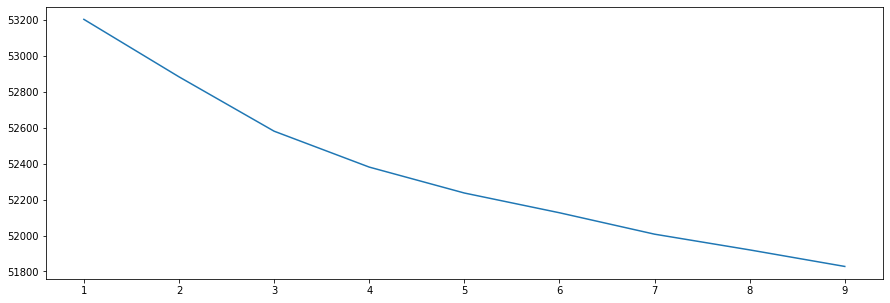

In [273]:
import math
#k vs inertia
fig,axs =  plt.subplots(1,1,squeeze=False,figsize=(15,5))
axs[0][0].plot(k,inertia)

best_k=1
maxx=-1
for i in range(len(inertia)-1):
    if abs(inertia[i+1]-inertia[i])>maxx:
        maxx=abs(inertia[i+1]-inertia[i])
        best_k+=1
print(best_k) 

In [275]:
kmeans=KMeans(n_clusters=best_k).fit(X)

In [276]:
kmeans.labels_.shape[0]
all_clusters=[]
clist=[]
for i in range(best_k):
    each_cluster=[]
    all_clusters.append(each_cluster)
    clist.append(i)
str_each_cluster=all_clusters

print(str_each_cluster)
index=None
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] in clist:
        index=clist.index(kmeans.labels_[i])
        all_clusters[index].append(str(preprocessed_reviews[i])) 
summ=0
for i in range(best_k):
    print('Number of reviews with label '+str(i)+' are '+str(len(all_clusters[i])))
    for h in range(0,len(all_clusters[i])):
        str_each_cluster[i]+=all_clusters[i][h]

[[], []]
Number of reviews with label 0 are 45877
Number of reviews with label 1 are 8579


In [277]:
print(kmeans.fit_predict(kmeans.cluster_centers_))

[0 1]


### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

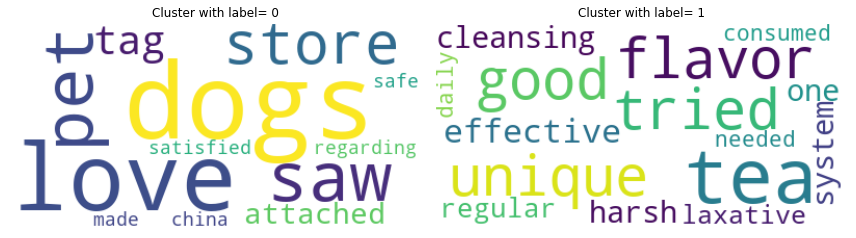

In [278]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
row=0
if best_k%2==0:
    row=best_k//2
else:
    row=best_k//2+1

fig,axs =  plt.subplots(row,2,squeeze=False,figsize=(12,12))
r,c=0,0
for i in range(best_k):
    if i%2!=0:
        c=+1
    else:
        c=0
        if i>1:
            r+=1
    wordcloud_spam = WordCloud(background_color="white").generate(str_each_cluster[i][0])
    axs[r][c].imshow(wordcloud_spam, interpolation='bilinear')
    axs[r][c].title.set_text("Cluster with label= "+str(i))
    axs[r][c].axis("off")
    fig.tight_layout()
plt.show()

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [279]:
list_of_sentance_train=[]
for sentance in preprocessed_reviews:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

X=sent_vectors_train
k=range(1,10)
inertia=[]
for i in k:
    kmeans=KMeans(n_clusters=i).fit(X)
    inertia.append(kmeans.inertia_)

100%|██████████| 54456/54456 [01:34<00:00, 576.98it/s]


54456
50


In [280]:
print(len(k),len(inertia))

9 9


2


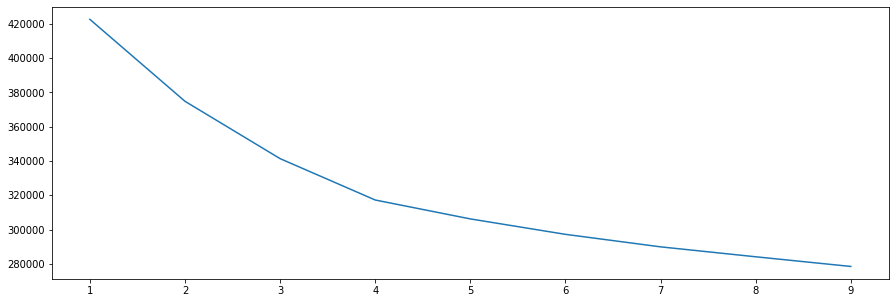

In [281]:
import math
#k vs inertia
fig,axs =  plt.subplots(1,1,squeeze=False,figsize=(15,5))
axs[0][0].plot(k,inertia)

best_k=1
maxx=-1
for i in range(len(inertia)-1):
    if abs(inertia[i+1]-inertia[i])>maxx:
        maxx=abs(inertia[i+1]-inertia[i])
        best_k+=1
print(best_k) 

In [283]:
kmeans=KMeans(n_clusters=best_k).fit(X)

In [284]:
kmeans.labels_.shape[0]
all_clusters=[]
clist=[]
for i in range(best_k):
    each_cluster=[]
    all_clusters.append(each_cluster)
    clist.append(i)
str_each_cluster=all_clusters

print(str_each_cluster)
index=None
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] in clist:
        index=clist.index(kmeans.labels_[i])
        all_clusters[index].append(str(preprocessed_reviews[i])) 
summ=0
for i in range(best_k):
    print('Number of reviews with label '+str(i)+' are '+str(len(all_clusters[i])))
    for h in range(0,len(all_clusters[i])):
        str_each_cluster[i]+=all_clusters[i][h]

[[], []]
Number of reviews with label 0 are 28544
Number of reviews with label 1 are 25912


In [285]:
print(kmeans.fit_predict(kmeans.cluster_centers_))

[1 0]


### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

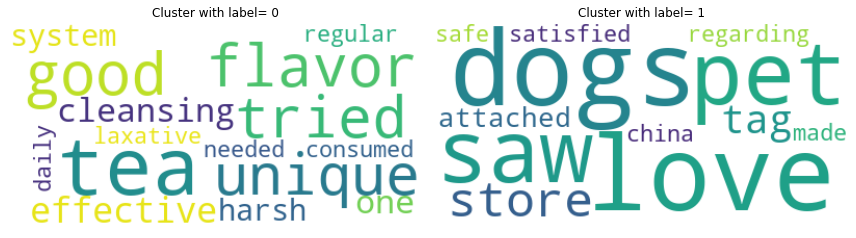

In [286]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
row=0
if best_k%2==0:
    row=best_k//2
else:
    row=best_k//2+1

fig,axs =  plt.subplots(row,2,squeeze=False,figsize=(12,12))
r,c=0,0
for i in range(best_k):
    if i%2!=0:
        c=+1
    else:
        c=0
        if i>1:
            r+=1
    wordcloud_spam = WordCloud(background_color="white").generate(str_each_cluster[i][0])
    axs[r][c].imshow(wordcloud_spam, interpolation='bilinear')
    axs[r][c].title.set_text("Cluster with label= "+str(i))
    axs[r][c].axis("off")
    fig.tight_layout()
plt.show()

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [287]:
list_of_sentance_train=[]
#w2v
for sentance in preprocessed_reviews:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
#tf-idf
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names()

x_train2 = []; 
row=0;
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_train2.append(sent_vec)
    row += 1
X=x_train2
print(len(x_train2))

X=sent_vectors_train
k=range(1,10)
inertia=[]
for i in k:
    kmeans=KMeans(n_clusters=i).fit(X)
    inertia.append(kmeans.inertia_)

100%|██████████| 54456/54456 [19:27<00:00, 46.62it/s] 


54456


In [288]:
print(len(k),len(inertia))

9 9


2


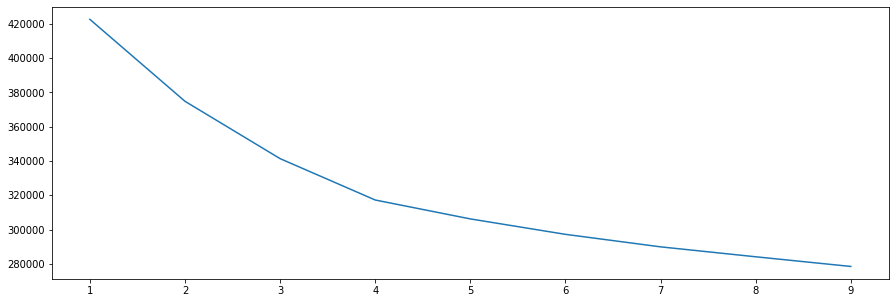

In [289]:
import math
#k vs inertia
fig,axs =  plt.subplots(1,1,squeeze=False,figsize=(15,5))
axs[0][0].plot(k,inertia)

best_k=1
maxx=-1
for i in range(len(inertia)-1):
    if abs(inertia[i+1]-inertia[i])>maxx:
        maxx=abs(inertia[i+1]-inertia[i])
        best_k+=1
print(best_k) 

In [291]:
kmeans=KMeans(n_clusters=best_k).fit(X)

In [292]:
kmeans.labels_.shape[0]
all_clusters=[]
clist=[]
for i in range(best_k):
    each_cluster=[]
    all_clusters.append(each_cluster)
    clist.append(i)
str_each_cluster=all_clusters

print(str_each_cluster)
index=None
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] in clist:
        index=clist.index(kmeans.labels_[i])
        all_clusters[index].append(str(preprocessed_reviews[i])) 
summ=0
for i in range(best_k):
    print('Number of reviews with label '+str(i)+' are '+str(len(all_clusters[i])))
    for h in range(0,len(all_clusters[i])):
        str_each_cluster[i]+=all_clusters[i][h]

[[], []]
Number of reviews with label 0 are 28363
Number of reviews with label 1 are 26093


In [293]:
print(kmeans.fit_predict(kmeans.cluster_centers_))

[0 1]


### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

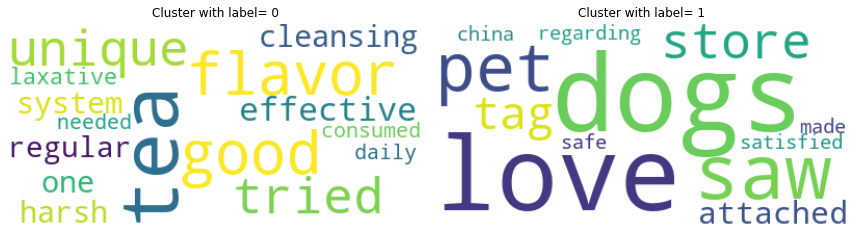

In [294]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
row=0
if best_k%2==0:
    row=best_k//2
else:
    row=best_k//2+1

fig,axs =  plt.subplots(row,2,squeeze=False,figsize=(12,12))
r,c=0,0
for i in range(best_k):
    if i%2!=0:
        c=+1
    else:
        c=0
        if i>1:
            r+=1
    wordcloud_spam = WordCloud(background_color="white").generate(str_each_cluster[i][0])
    axs[r][c].imshow(wordcloud_spam, interpolation='bilinear')
    axs[r][c].title.set_text("Cluster with label= "+str(i))
    axs[r][c].axis("off")
    fig.tight_layout()
plt.show()

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [295]:
list_of_sentance_train=[]
for sentance in preprocessed_reviews[0:10000]:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

X=sent_vectors_train

100%|██████████| 10000/10000 [00:11<00:00, 836.63it/s]

10000
50


<h6>With k=2<h6>

In [296]:
best_k=2

In [297]:
from sklearn.cluster import AgglomerativeClustering
agglo=AgglomerativeClustering(n_clusters=best_k).fit(X)

In [298]:
agglo.labels_.shape[0]
all_clusters=[]
clist=[]
for i in range(best_k):
    each_cluster=[]
    all_clusters.append(each_cluster)
    clist.append(i)
str_each_cluster=all_clusters

print(str_each_cluster)
index=None
for i in range(agglo.labels_.shape[0]):
    if agglo.labels_[i] in clist:
        index=clist.index(agglo.labels_[i])
        all_clusters[index].append(str(preprocessed_reviews[i])) 
summ=0
for i in range(best_k):
    print('Number of reviews with label '+str(i)+' are '+str(len(all_clusters[i])))
    for h in range(0,len(all_clusters[i])):
        str_each_cluster[i]+=all_clusters[i][h]

[[], []]
Number of reviews with label 0 are 4634
Number of reviews with label 1 are 5366


### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

<h5>number of clusters = 2<h5>

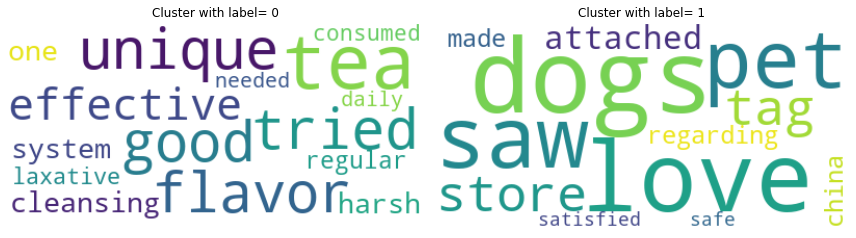

In [299]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
row=0
if best_k%2==0:
    row=best_k//2
else:
    row=best_k//2+1

fig,axs =  plt.subplots(row,2,squeeze=False,figsize=(12,12))
r,c=0,0
for i in range(best_k):
    if i%2!=0:
        c=+1
    else:
        c=0
        if i>1:
            r+=1
    wordcloud_spam = WordCloud(background_color="white").generate(str_each_cluster[i][0])
    axs[r][c].imshow(wordcloud_spam, interpolation='bilinear')
    axs[r][c].title.set_text("Cluster with label= "+str(i))
    axs[r][c].axis("off")
    fig.tight_layout()
plt.show()

<h6>with k=5<h6>

In [300]:
best_k=5

In [301]:
from sklearn.cluster import AgglomerativeClustering
agglo=AgglomerativeClustering(n_clusters=best_k).fit(X)

In [302]:
agglo.labels_.shape[0]
all_clusters=[]
clist=[]
for i in range(best_k):
    each_cluster=[]
    all_clusters.append(each_cluster)
    clist.append(i)
str_each_cluster=all_clusters

print(str_each_cluster)
index=None
for i in range(agglo.labels_.shape[0]):
    if agglo.labels_[i] in clist:
        index=clist.index(agglo.labels_[i])
        all_clusters[index].append(str(preprocessed_reviews[i])) 
summ=0
for i in range(best_k):
    print('Number of reviews with label '+str(i)+' are '+str(len(all_clusters[i])))
    for h in range(0,len(all_clusters[i])):
        str_each_cluster[i]+=all_clusters[i][h]

[[], [], [], [], []]
Number of reviews with label 0 are 3190
Number of reviews with label 1 are 1815
Number of reviews with label 2 are 1444
Number of reviews with label 3 are 2597
Number of reviews with label 4 are 954


### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

<h5>number of clusters = 5<h5>

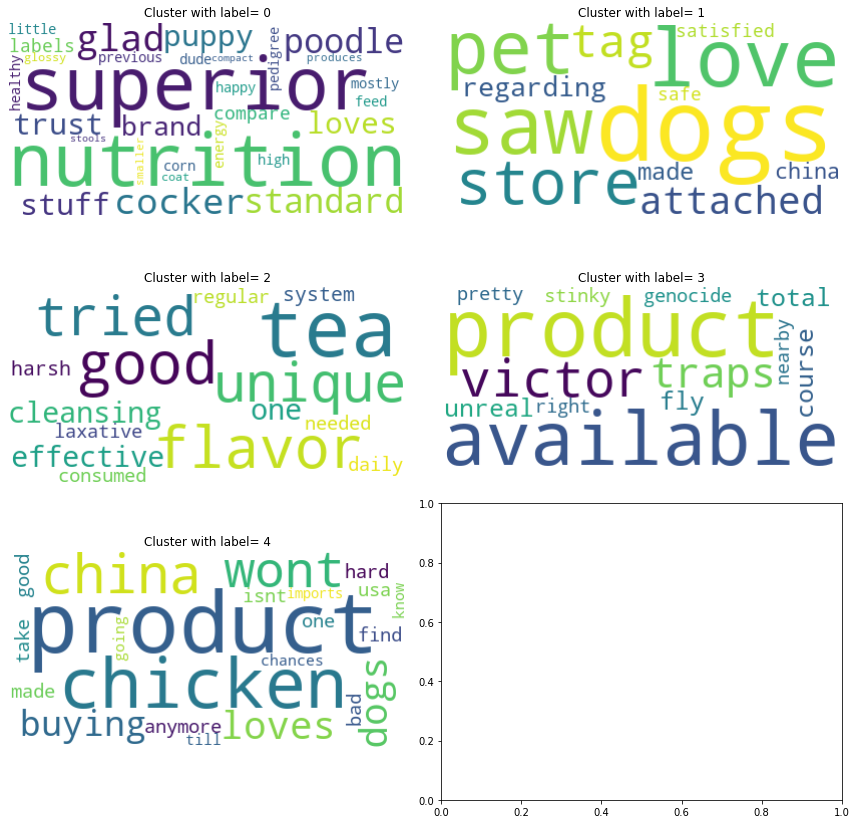

In [303]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
row=0
if best_k%2==0:
    row=best_k//2
else:
    row=best_k//2+1

fig,axs =  plt.subplots(row,2,squeeze=False,figsize=(12,12))
r,c=0,0
for i in range(best_k):
    if i%2!=0:
        c=+1
    else:
        c=0
        if i>1:
            r+=1
    wordcloud_spam = WordCloud(background_color="white").generate(str_each_cluster[i][0])
    axs[r][c].imshow(wordcloud_spam, interpolation='bilinear')
    axs[r][c].title.set_text("Cluster with label= "+str(i))
    axs[r][c].axis("off")
    fig.tight_layout()
plt.show()

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [304]:
# Please write all the code with proper documentation
list_of_sentance_train=[]
#w2v
for sentance in preprocessed_reviews[0:10000]:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
#tf-idf
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names()

x_train2 = []; 
row=0;
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_train2.append(sent_vec)
    row += 1
X=x_train2
print(len(x_train2))

100%|██████████| 10000/10000 [02:41<00:00, 62.01it/s]

10000


<h6>With k=2<h6>

In [305]:
best_k=2

In [306]:
from sklearn.cluster import AgglomerativeClustering
agglo=AgglomerativeClustering(n_clusters=best_k).fit(X)

In [307]:
agglo.labels_.shape[0]
all_clusters=[]
clist=[]
for i in range(best_k):
    each_cluster=[]
    all_clusters.append(each_cluster)
    clist.append(i)
str_each_cluster=all_clusters

print(str_each_cluster)
index=None
for i in range(agglo.labels_.shape[0]):
    if agglo.labels_[i] in clist:
        index=clist.index(agglo.labels_[i])
        all_clusters[index].append(str(preprocessed_reviews[i])) 
summ=0
for i in range(best_k):
    print('Number of reviews with label '+str(i)+' are '+str(len(all_clusters[i])))
    for h in range(0,len(all_clusters[i])):
        str_each_cluster[i]+=all_clusters[i][h]

[[], []]
Number of reviews with label 0 are 3511
Number of reviews with label 1 are 6489


### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

<h5>number of clusters = 2<h5>

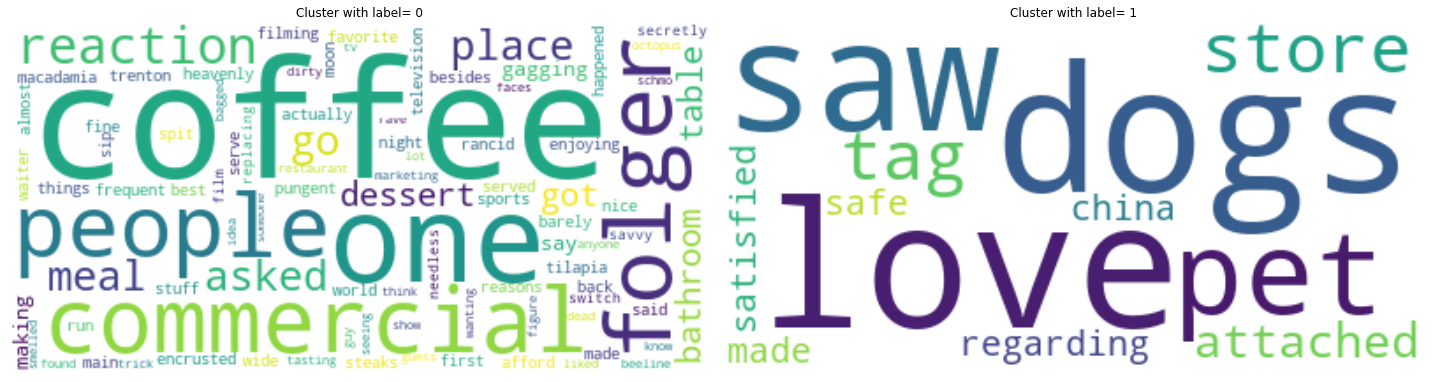

In [308]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
row=0
if best_k%2==0:
    row=best_k//2
else:
    row=best_k//2+1

fig,axs =  plt.subplots(row,2,squeeze=False,figsize=(20,20))
r,c=0,0
for i in range(best_k):
    if i%2!=0:
        c=+1
    else:
        c=0
        if i>1:
            r+=1
    wordcloud_spam = WordCloud(background_color="white").generate(str_each_cluster[i][0])
    axs[r][c].imshow(wordcloud_spam, interpolation='bilinear')
    axs[r][c].title.set_text("Cluster with label= "+str(i))
    axs[r][c].axis("off")
    fig.tight_layout()
plt.show()

<h6>with k=5<h6>

In [309]:
best_k=5

In [310]:
from sklearn.cluster import AgglomerativeClustering
agglo=AgglomerativeClustering(n_clusters=best_k).fit(X)

In [311]:
agglo.labels_.shape[0]
all_clusters=[]
clist=[]
for i in range(best_k):
    each_cluster=[]
    all_clusters.append(each_cluster)
    clist.append(i)
str_each_cluster=all_clusters

print(str_each_cluster)
index=None
for i in range(agglo.labels_.shape[0]):
    if agglo.labels_[i] in clist:
        index=clist.index(agglo.labels_[i])
        all_clusters[index].append(str(preprocessed_reviews[i])) 
summ=0
for i in range(best_k):
    print('Number of reviews with label '+str(i)+' are '+str(len(all_clusters[i])))
    for h in range(0,len(all_clusters[i])):
        str_each_cluster[i]+=all_clusters[i][h]

[[], [], [], [], []]
Number of reviews with label 0 are 2256
Number of reviews with label 1 are 4120
Number of reviews with label 2 are 1255
Number of reviews with label 3 are 1705
Number of reviews with label 4 are 664


### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

<h5>number of clusters = 5<h5>

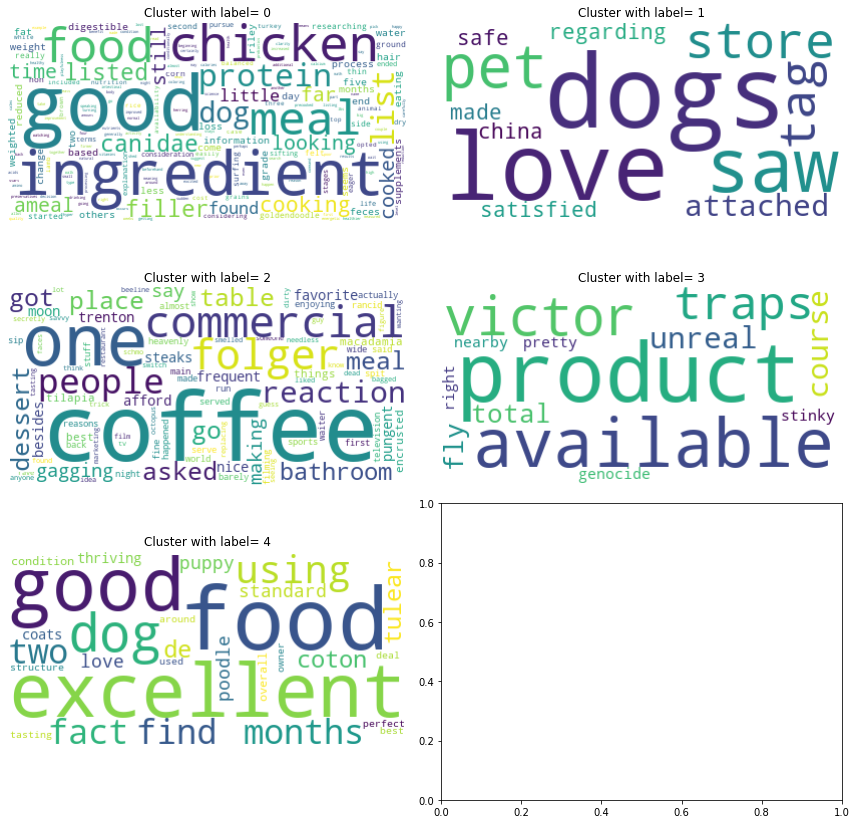

In [312]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
row=0
if best_k%2==0:
    row=best_k//2
else:
    row=best_k//2+1

fig,axs =  plt.subplots(row,2,squeeze=False,figsize=(12,12))
r,c=0,0
for i in range(best_k):
    if i%2!=0:
        c=+1
    else:
        c=0
        if i>1:
            r+=1
    wordcloud_spam = WordCloud(background_color="white").generate(str_each_cluster[i][0])
    axs[r][c].imshow(wordcloud_spam, interpolation='bilinear')
    axs[r][c].title.set_text("Cluster with label= "+str(i))
    axs[r][c].axis("off")
    fig.tight_layout()
plt.show()

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [325]:
list_of_sentance_train=[]
for sentance in preprocessed_reviews[0:30000:3]:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

X=sent_vectors_train

100%|██████████| 10000/10000 [00:10<00:00, 963.43it/s]

10000
50


Epsilion is 1.0050639038707043
min_pts is 100


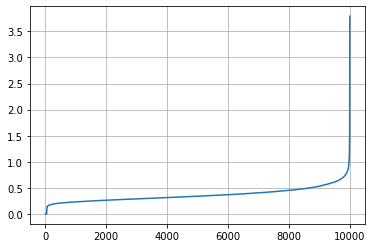

In [326]:
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
#https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf
#Used above resources for logic and code
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=100)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.grid()
plt.plot(distances)
maxx=-1
for i in range(len(distances)-1):
    if abs(distances[i+1]-distances[i])>maxx:
        maxx=abs(distances[i+1]-distances[i])
print('Epsilion is {}'.format(maxx)) 
#min_points=2*dimensionality
min_pts=2*len(sent_vectors_train[0])
print('min_pts is {}'.format(min_pts)) 

In [332]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN(eps=maxx,min_samples=min_pts).fit(X)
best_k=len(set(dbscan.labels_))
all_clusters=[]
clist=[]
for i in range(len(set(dbscan.labels_))):
    each_cluster=[]
    all_clusters.append(each_cluster)
    clist.append(i)
str_each_cluster=all_clusters
print(dbscan.labels_.shape[0])
print(str_each_cluster)
index=None
for i in range(dbscan.labels_.shape[0]):
    if dbscan.labels_[i] in clist:
        index=clist.index(dbscan.labels_[i])
        all_clusters[index].append(str(preprocessed_reviews[i])) 
summ=0
for i in range(len(set(dbscan.labels_))):
    print('Number of reviews with label '+str(i)+' are '+str(len(all_clusters[i])))
    for h in range(0,len(all_clusters[i])):
        str_each_cluster[i]+=all_clusters[i][h]

10000
[[], []]
Number of reviews with label 0 are 9883
Number of reviews with label 1 are 0


In [360]:
# Please write all the code with proper documentation
#https://stackoverflow.com/questions/59775679/why-are-all-labels-are-1-generated-by-dbscan-in-python
print('Noisy samples are given the label -1')
print(set(dbscan.labels_))

Noisy samples are given the label -1
{0, -1}


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

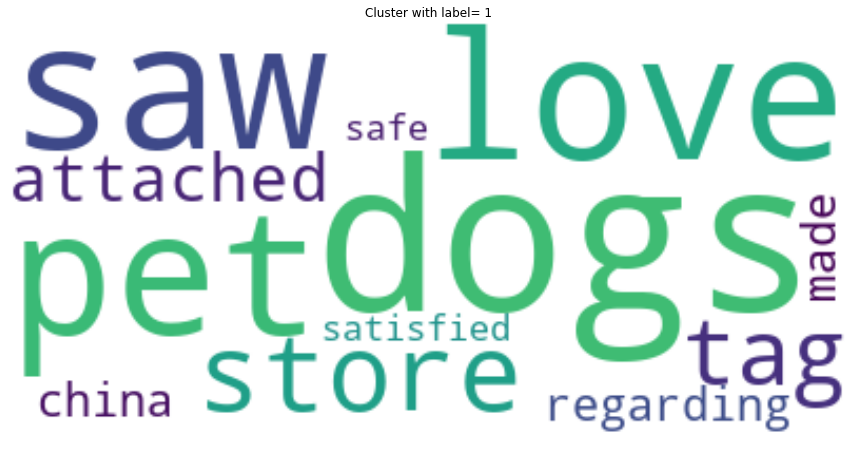

In [337]:
fig,axs =  plt.subplots(1,1,squeeze=False,figsize=(12,12))
r,c=0,0
wordcloud_spam = WordCloud(background_color="white").generate(str_each_cluster[0][0])
axs[r][c].imshow(wordcloud_spam, interpolation='bilinear')
axs[r][c].title.set_text("Cluster with label= "+str(i))
axs[r][c].axis("off")
fig.tight_layout()
plt.show()

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [338]:
# Please write all the code with proper documentation
list_of_sentance_train=[]
#w2v
for sentance in preprocessed_reviews[0:30000:3]:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
#tf-idf
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names()

x_train2 = []; 
row=0;
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_train2.append(sent_vec)
    row += 1
X=x_train2
print(len(x_train2[0]))

100%|██████████| 10000/10000 [02:29<00:00, 66.82it/s]

50


Epsilion is 1.265443032072104
min_pts is 100


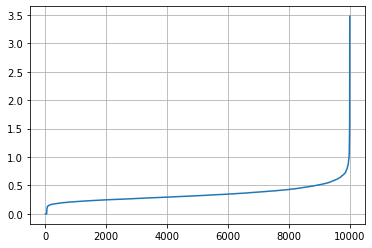

In [339]:
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
#https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf
#Used above resources for logic and code
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=100)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.grid()
plt.plot(distances)
maxx=-1
for i in range(len(distances)-1):
    if abs(distances[i+1]-distances[i])>maxx:
        maxx=abs(distances[i+1]-distances[i])
print('Epsilion is {}'.format(maxx)) 
#min_points=2*dimensionality
min_pts=2*len(X[0])
print('min_pts is {}'.format(min_pts)) 

In [343]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN(eps=maxx,min_samples=min_pts).fit(X)
best_k=len(set(dbscan.labels_))
all_clusters=[]
clist=[]
for i in range(len(set(dbscan.labels_))):
    each_cluster=[]
    all_clusters.append(each_cluster)
    clist.append(i)
str_each_cluster=all_clusters

print(str_each_cluster)
index=None
for i in range(dbscan.labels_.shape[0]):
    if dbscan.labels_[i] in clist:
        index=clist.index(dbscan.labels_[i])
        all_clusters[index].append(str(preprocessed_reviews[i])) 
summ=0
for i in range(len(set(dbscan.labels_))):
    print('Number of reviews with label '+str(i)+' are '+str(len(all_clusters[i])))
    for h in range(0,len(all_clusters[i])):
        str_each_cluster[i]+=all_clusters[i][h]

[[], []]
Number of reviews with label 0 are 9295
Number of reviews with label 1 are 0


In [361]:
# Please write all the code with proper documentation
#https://stackoverflow.com/questions/59775679/why-are-all-labels-are-1-generated-by-dbscan-in-python
print('Noisy samples are given the label -1')
print(set(dbscan.labels_))

Noisy samples are given the label -1
{0, -1}


### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

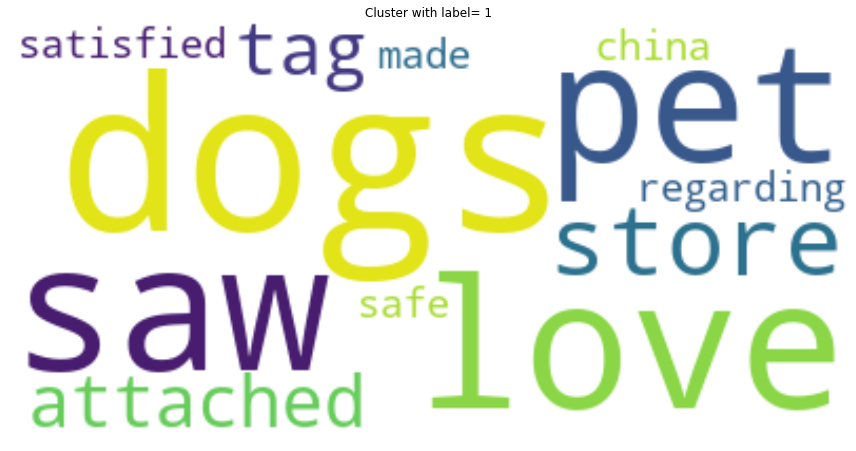

In [345]:
fig,axs =  plt.subplots(1,1,squeeze=False,figsize=(12,12))
r,c=0,0
wordcloud_spam = WordCloud(background_color="white").generate(str_each_cluster[0][0])
axs[r][c].imshow(wordcloud_spam, interpolation='bilinear')
axs[r][c].title.set_text("Cluster with label= "+str(i))
axs[r][c].axis("off")
fig.tight_layout()
plt.show()

# [6] Conclusions

In [351]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan
from prettytable import PrettyTable
x = PrettyTable()
print('K-means')
x.field_names = ["Vectorizer","k"]
x.add_row(['BOW','2'])
x.add_row(['TFIDF','2'])
x.add_row(['AVG W2vec','2'])
x.add_row(['TFIDF W2vec','2'])
print(x)

K-means
+-------------+---+
|  Vectorizer | k |
+-------------+---+
|     BOW     | 2 |
|    TFIDF    | 2 |
|  AVG W2vec  | 2 |
| TFIDF W2vec | 2 |
+-------------+---+


Even though k was 2 for all implementations of K-means,each implementation gave different results which are as follows:

#### K-means on Bag of words:<br>
Number of reviews with label 0 are 45549<br>
Number of reviews with label 1 are 8907<br>
#### K-means on TF-IDF:<br>
Number of reviews with label 0 are 45877<br>
Number of reviews with label 1 are 8579<br>
#### K-means on Avg-W2v:<br>
Number of reviews with label 0 are 28544<br>
Number of reviews with label 1 are 25912<br>
#### K-means on TF-IDF W2v:<br>
Number of reviews with label 0 are 28363<br>
Number of reviews with label 1 are 26093<br>

### Agglomerative clustering
#### Agglomerative clustering on Avg-W2v with k=2:<br>
Number of reviews with label 0 are 4634<br>
Number of reviews with label 1 are 5366<br>
#### Agglomerative clustering on Avg-W2v with k=5:<br>
Number of reviews with label 0 are 3190<br>
Number of reviews with label 1 are 1815<br>
Number of reviews with label 2 are 1444<br>
Number of reviews with label 3 are 2597<br>
Number of reviews with label 4 are 954<br>
<br>
#### Agglomerative clustering on TFIDF-W2v with k=2:<br>
Number of reviews with label 0 are 3511<br>
Number of reviews with label 1 are 6489<br>
#### Agglomerative clustering on TFIDF-W2v with k=5:<br>
Number of reviews with label 0 are 2256<br>
Number of reviews with label 1 are 4120<br>
Number of reviews with label 2 are 1255<br>
Number of reviews with label 3 are 1705<br>
Number of reviews with label 4 are 664<br>

### DBSCAN

In [357]:
x = PrettyTable()
print('DBSCAN')
print('Min_pts is considered 2 times the dimentionality(50).')
x.field_names = ["Vectorizer","Epsilon","Min_pts"]
x.add_row(['AVG W2vec','1.005','100'])
x.add_row(['TFIDF W2vec','1.265','100'])
print(x)

DBSCAN
Min_pts is considered 2 times the dimentionality(50).
+-------------+---------+---------+
|  Vectorizer | Epsilon | Min_pts |
+-------------+---------+---------+
|  AVG W2vec  |  1.005  |   100   |
| TFIDF W2vec |  1.265  |   100   |
+-------------+---------+---------+
